__Author:__ Andrew Lesak - 10/02/23

__Purpose:__ Fit Molly's mouse prey capture data to ARHMM

# Imports
____

In [1]:
# run 'pip install library_name' if you dont have a library installed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from distinctipy import distinctipy
from itertools import groupby
from operator import itemgetter

# need to use autograd.numpy for some ssm stuff
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(3)
import ssm
from ssm.plots import gradient_cmap

# need for performing cross validation
import multiprocessing
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
cmap_cv = plt.cm.coolwarm

# Load data
____

Get file path for data that Molly shared with me in the prey capture dropbox

In [2]:
path     = "/home/alesak/alesak/preycaptureHMM_updated/"
csv_name = "flattened_geometries_allmice_LD_satiated_clipped_wframes.csv"

Make dataframe

In [20]:
# load data into df & drop filename column
df = pd.read_csv(path + csv_name)
df = df.drop(columns=["filename"])

# rename trial ids & frame columns
df = df.rename(columns={"Unnamed: 0":"trial_ID","localframe":"frame"})

# replace azimuth data 'az' with atanh(cos(az)) & atanh(sin(az))
az = np.pi/180*df['az'].to_numpy() # az is in degrees, first convert to rads
df.insert(4,"atanh_cos_az",np.arctanh(np.cos(az))) ## this is gaussian just from this
df.insert(5,"atanh_sin_az",np.arctanh(np.sin(az))) ## might need to take cube root after this, won't be gaussian without it
df.insert(2,"az_rad",az)
df = df.drop(columns="az") # drop az in degreees col

# drop nans & reindex (nans are from trial_IDs that include only 1 frame for some reason)
df = df.dropna() 
df = df.reset_index(drop=True)

# print trial ids
trial_ids = df["trial_ID"].unique().tolist()
print("Current IDs:",trial_ids)

Current IDs: [51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 2

In [21]:
df

,trial_ID,frame,az_rad,dist,atanh_cos_az,atanh_sin_az,mouse_spd,cricket_spd
0,51,2792.0,2.106690,42.561326,-0.563555,1.292625,13.459829,252.009088
1,51,2793.0,2.077170,42.822663,-0.529513,1.351934,5.358044,259.408277
2,51,2794.0,2.064158,42.742008,-0.514688,1.379082,8.576596,244.490150
3,51,2795.0,2.032522,43.076356,-0.479064,1.447941,8.906037,240.374887
4,51,2796.0,2.001495,43.362325,-0.444668,1.519865,9.127864,236.798880
...,...,...,...,...,...,...,...,...
10633342,2461,9778.0,0.274543,3.827463,1.979485,0.278059,31.409355,13.160123
10633343,2461,9779.0,0.274660,3.702472,1.979055,0.278180,30.618819,11.743372
10633344,2461,9780.0,0.239649,3.610869,2.116925,0.241977,28.749787,7.466669
10633345,2461,9781.0,0.295444,3.636880,1.905112,0.299838,31.135584,6.499485


### z score speeds and range

Get the duration of each trial

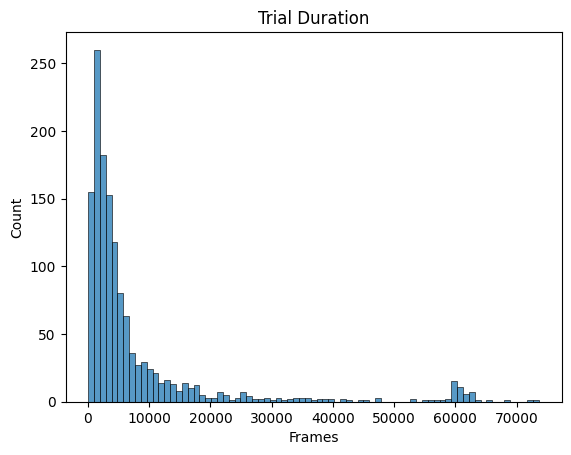

In [22]:
trial_lens = []
for i in df["trial_ID"].unique():
    t_sel = (df["trial_ID"] == i)
    trial_lens.append(len(df[t_sel]))

sns.histplot(trial_lens)
plt.title("Trial Duration")
plt.xlabel("Frames")
plt.show()

## Select only shorter trials & make dataframe

If we keep the data limited to trials in which the mouse is successful at hunting, then we will have a lot more useful hunting pursuit motifs to fit. I'm choosing an arbitrary cut off of 20000 frames = 100 seconds to capture.

In [23]:
# select frame cutoff
frame_cutoff = 20000

# get ids of short trials
short_trial_IDs = []
for i in df["trial_ID"].unique():
    t_sel = (df["trial_ID"] == i)
    if len(df[t_sel]) <= frame_cutoff: 
        short_trial_IDs.append(i)

# make new dataframe of only short trials
short_dur_sel = df["trial_ID"].isin(short_trial_IDs)
short_df = df[short_dur_sel].copy()

In [24]:
short_df

,trial_ID,frame,az_rad,dist,atanh_cos_az,atanh_sin_az,mouse_spd,cricket_spd
0,51,2792.0,2.106690,42.561326,-0.563555,1.292625,13.459829,252.009088
1,51,2793.0,2.077170,42.822663,-0.529513,1.351934,5.358044,259.408277
2,51,2794.0,2.064158,42.742008,-0.514688,1.379082,8.576596,244.490150
3,51,2795.0,2.032522,43.076356,-0.479064,1.447941,8.906037,240.374887
4,51,2796.0,2.001495,43.362325,-0.444668,1.519865,9.127864,236.798880
...,...,...,...,...,...,...,...,...
10633342,2461,9778.0,0.274543,3.827463,1.979485,0.278059,31.409355,13.160123
10633343,2461,9779.0,0.274660,3.702472,1.979055,0.278180,30.618819,11.743372
10633344,2461,9780.0,0.239649,3.610869,2.116925,0.241977,28.749787,7.466669
10633345,2461,9781.0,0.295444,3.636880,1.905112,0.299838,31.135584,6.499485


# Downsample data in 'short_df'
_____

## Test downsampling on single trial

Find a good downsample factor 'q'

In [31]:
# select trial
trial_num = 211

# select var in df to plot
var = "atanh_cos_az"

# get data
t_sel = (short_df["trial_ID"]==trial_num)
obs = np.array(short_df[t_sel][var],dtype=float)
obs.shape

(9061,)

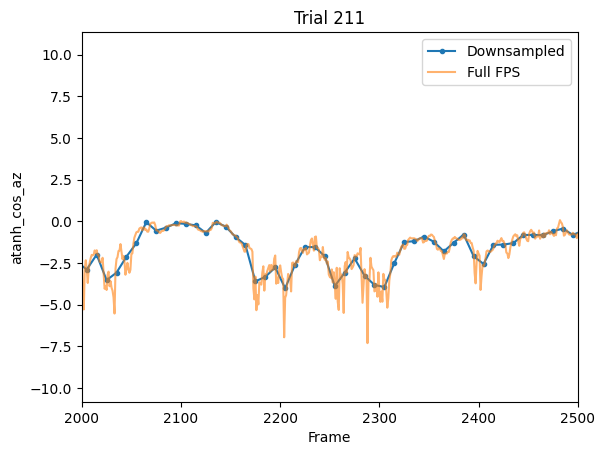

In [32]:
# downsample by factor 'q'
q = 10

# downsample observations
ds_obs = signal.decimate(obs,q,axis=0)

# plot 
xs = np.linspace(short_df[t_sel]["frame"].min(),short_df[t_sel]["frame"].max(),ds_obs.shape[0])
plt.plot(xs,ds_obs,'.-',label="Downsampled")
plt.plot(short_df[t_sel]["frame"],short_df[t_sel][var],alpha=0.6,label="Full FPS")
plt.xlim(2000,2500)
plt.xlabel("Frame"), plt.ylabel(var)
plt.title("Trial {}".format(trial_num))
plt.legend()
plt.show()

## Downsample all data

Get data

In [41]:
# get all the variables in df minus "trial_ID" & "frame" (will add later)
vars = short_df.columns.tolist()
vars.remove("trial_ID")
vars.remove("frame")
print("Vars: {}".format(vars))
# MAKE SURE FRAME IS LAST VARIABLES IN LIST!!!!!
vars += ["frame"] 

# get data for each trial and add to list
t_datas = [[] for _ in range(len(vars))]
for i in short_df["trial_ID"].unique():
    t_sel = (short_df["trial_ID"]==i)
    for i,var in enumerate(vars):
        t_datas[i].append(short_df[t_sel][var].to_numpy())

Vars: ['az_rad', 'dist', 'atanh_cos_az', 'atanh_sin_az', 'mouse_spd', 'cricket_spd']


Downsample data

In [42]:
# downsample by factor q
q = 10

# get downsampled datas
ds_datas = [[] for _ in range(len(vars)+1)] # add extra spot in list for trial_ID
for i,j in enumerate(short_df["trial_ID"].unique()):
    
    # downsample data
    # exclude the last variable "frames" bc we dont want to decimate the frames, rather linearly interpolate
    for k in range(len(vars[:-1])):
        ds_datas[k].append(signal.decimate(t_datas[k][i],q))
    
    # get num of downsampled points
    num_ds_frames = len(ds_datas[k][i])
    # linearly interpolate frames since downsampling has weird effect and changes the start/end frame values
    ds_datas[-2].append(np.linspace(t_datas[-1][i].min(),t_datas[-1][i].max(),num_ds_frames))
    # append list of trial ID the same length as session data
    ds_datas[-1].append([int(j)]*num_ds_frames)

Make dataframe for downsampled data

In [43]:
# concatenate datas
ds_df_list = [np.concatenate(ds_datas[i]) for i in range(len(ds_datas))]
# make df of downsampled data
ds_df_indices = vars + ["trial_ID"]
ds_df = pd.DataFrame(ds_df_list,index = ds_df_indices).T

In [44]:
ds_df

,az_rad,dist,atanh_cos_az,atanh_sin_az,mouse_spd,cricket_spd,frame,trial_ID
0,2.089646,42.077504,-0.564276,1.296001,13.643711,249.609805,2792.000000,51.0
1,1.885186,44.083911,-0.338927,1.706917,1.221127,202.951434,2802.051020,51.0
2,1.685734,47.259905,-0.136883,3.633539,2.950767,147.142706,2812.102041,51.0
3,1.344701,49.087275,0.217950,2.459552,9.251659,104.724232,2822.153061,51.0
4,0.991931,50.819120,0.587295,1.076161,3.652580,82.495246,2832.204082,51.0
...,...,...,...,...,...,...,...,...
540637,0.156148,2.824583,2.600530,0.162011,18.239490,37.933340,9741.960640,2461.0
540638,0.189366,3.483556,2.500187,0.190919,29.050458,43.887390,9751.970480,2461.0
540639,0.256378,3.973925,2.107262,0.257695,29.250706,33.030721,9761.980320,2461.0
540640,0.323623,3.989984,1.804425,0.334069,30.503688,34.788397,9771.990160,2461.0


# Get lagged observations of downsampled data
____

## Functions

In [45]:
def get_lagged_data(df,trial_num,vars,lag):
    """
    Get lagged data for a specified trial
    """
    assert lag>=0
    # select group & get data
    t_sel = (df['trial_ID']==trial_num)
    t_datas = [np.array(df[t_sel][var],dtype=float) for var in vars]

    # get indices to make room for lags
    num_frames = len(df[t_sel]["frame"])
    idx = np.arange(0,num_frames)
    idx = idx[(idx >= lag) & (idx < num_frames-lag)]

    # get lagged observations
    t_lag_datas = [[] for _ in range(len(vars))]
    for i in range(len(vars)):
        t_lag_datas[i] = [list(t_datas[i][j-lag:j+(lag+1)]) for j in idx]

    # get frames & append to lagged data list
    min_frame = df[t_sel]["frame"].iloc[lag]
    max_frame = df[t_sel]["frame"].iloc[-(lag+1)]
    frames = list(np.linspace(min_frame,max_frame,len(idx)))
    t_lag_datas.append(frames)

    # get trial & append to lagged data list
    trial = [trial_num]*len(idx)
    t_lag_datas.append(trial)

    return t_lag_datas

In [46]:
def get_all_data(df,vars,lag):
    """
    Gets lagged data for all trials and returns a list
    """
    lag_datas = [[] for _ in range(len(vars)+2)] # add 2 bc we include frames & trial_ID
    for i in df["trial_ID"].unique():
        t_sel = (df['trial_ID']==i)
        if len(df[t_sel]) > (2*lag+1): # make sure trial length is long enough
            t_lag_datas = get_lagged_data(df,i,vars,lag)
            for j in range(len(t_lag_datas)):
                lag_datas[j] += t_lag_datas[j]
        else:
            continue
        
    return lag_datas

# Make dataframe for lagged data

'lag' defines the number of frame datas forwards & backwards we keep in our observations for each frame.

In [47]:
# select variables to include in our observations
vars = ['dist','atanh_cos_az','mouse_spd']
# select number of lags
lag = 0

# get lagged data
lagged_data = get_all_data(ds_df,vars,lag)
# make dataframe
lag_df = pd.DataFrame(lagged_data, index=vars+["frame"]+["trial_ID"]).T

In [48]:
lag_df

,dist,atanh_cos_az,mouse_spd,frame,trial_ID
0,[42.07750361525579],[-0.5642761899249294],[13.643711092965825],2792.0,51.0
1,[44.083911120331464],[-0.3389273888521519],[1.2211265702560934],2802.05102,51.0
2,[47.259904945277626],[-0.13688265061767949],[2.950766706335496],2812.102041,51.0
3,[49.087275053491986],[0.21795025513772098],[9.251658571082626],2822.153061,51.0
4,[50.81912014452272],[0.5872948208880195],[3.652580228993394],2832.204082,51.0
...,...,...,...,...,...
540637,[2.8245826127661835],[2.600530268078423],[18.239490312748554],9741.96064,2461.0
540638,[3.483555522769109],[2.500187236762995],[29.05045760033117],9751.97048,2461.0
540639,[3.9739253020060588],[2.107261800906357],[29.250706034562835],9761.98032,2461.0
540640,[3.9899835555790926],[1.8044254116648455],[30.503687934221198],9771.99016,2461.0


# Get observations & fit ARHMM
___

z-score observations

In [49]:
# get observations
print("Vars: {}".format(vars))
print("Num lags: {}".format(lag))
obs = [np.vstack(lag_df[var]) for var in vars] # use vars selected when making lag_df above
obs = np.hstack(obs)
obs = np.array(obs,dtype=float) # make sure array is float type
# zscore obs
obs = stats.zscore(obs)
# get dim
obs_dim = obs.shape[-1]
print("Obs shape:",obs.shape)

Vars: ['dist', 'atanh_cos_az', 'mouse_spd']
Num lags: 0
Obs shape: (540642, 3)


The number of parameters $S$ in an AR(1)HMM model with $K$ states and observation dimension $D$:
- $K(K-1)$ from the transition matrix.
- $K-1$ from the initial state distribution.
- $K*D^2$ from the weights matrices $A$
- $K*D$ from the biases
- $K*D$ from a diagonal noise distribution (our model) or $K*D(D+1)/2$ for a full noise covariance matrix. 

In our case, $S=(K+1)(K-1)+K(D^2+2D) \approx K*D^2$ for large $D$. 

Select number of states and calculate the total number of model params

In [56]:
# define num of states
num_states = 5            

# get num params in model
def get_num_model_params(K=num_states,D=obs_dim,cov="diag"):
    if cov=="diag":
        S = (K+1)*(K-1) + K*(D**2 + 2*D)
    elif cov=="full":
        S = (K+1)*(K-1) + (3/2)*K*(D**2 + D)
    return(int(S))

print("Num. params (diag cov): {}".format(get_num_model_params(cov="diag")))
print("Num. params (full cov): {}".format(get_num_model_params(cov="full")))

Num. params (diag cov): 99
Num. params (full cov): 114


Fit ARHMM

  0%|          | 0/100 [00:00<?, ?it/s]

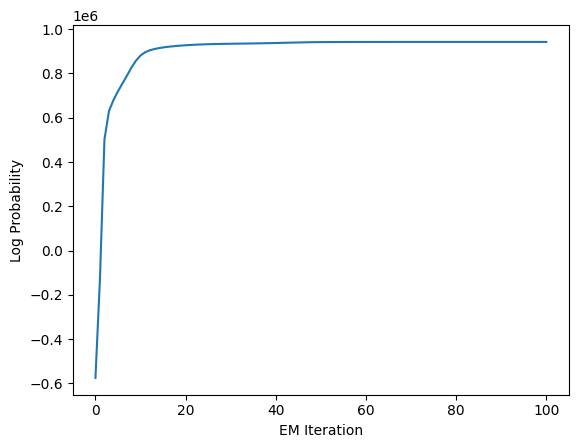

In [81]:
# define hyperparams
N_iters    = 20 # number of iterations to run EM algorithm (for some reason this doesnt work and model defaults to 100)
TOL        = 1e-4 # LL convergence threshold
trans_type = "sticky" # choose "stationary" or "sticky"
obs_type   = "ar" # choose "ar" for full covariance, "diagonal_ar" for diag cov

# instantiate ARHMM model
arhmm = ssm.HMM(K=num_states, D=obs_dim, observations=obs_type, transitions=trans_type)
if trans_type=="sticky": 
    arhmm.transitions.kappa = 1e6  #can tweak this sticky parameter

# fit model
training_lls = arhmm.fit(datas=obs, N_iter=N_iters, tolerance=TOL)
plt.plot(training_lls)
plt.xlabel("EM Iteration"),plt.ylabel("Log Probability")
plt.show()

## Get most likely states

### Add most likely state sequence & posterior state probability to "lag_df" dataframe

In [66]:
# get most likely states
arhmm_z = arhmm.most_likely_states(obs)
# get posteriors
posts = arhmm.expected_states(obs)[0]

# add to dataframe
if "state" in lag_df.columns.tolist(): lag_df = lag_df.drop(columns=["state"])
if "posts" in lag_df.columns.tolist(): lag_df = lag_df.drop(columns=["posts"])
lag_df.insert(0,"state",arhmm_z)
lag_df.insert(1,"posts",list(posts))

# get mask to segment data for each state
state_sel = [(lag_df["state"] == i) for i in range(num_states)]

# Export lag_df to make movies with
____

In order to make videos demonstrating each state, we need to have the state sequences. Let's save the downsampled lagged dataframe "lag_df". We also need the full data so let's save "short_df" also.

In [92]:
lag_df

,state,posts,dist,atanh_cos_az,mouse_spd,frame,trial_ID
0,2,"[3.123440277150803e-11, 1.1037491446361545e-09...",[42.07750361525579],[-0.5642761899249294],[13.643711092965825],2792.0,51.0
1,2,"[1.662079381087436e-17, 0.0001308723418900238,...",[44.083911120331464],[-0.3389273888521519],[1.2211265702560934],2802.05102,51.0
2,2,"[2.386006273360369e-28, 0.0002558796236762383,...",[47.259904945277626],[-0.13688265061767949],[2.950766706335496],2812.102041,51.0
3,2,"[7.70591163577857e-15, 0.0002492530740070094, ...",[49.087275053491986],[0.21795025513772098],[9.251658571082626],2822.153061,51.0
4,2,"[1.380142583706166e-13, 0.0003380057987646574,...",[50.81912014452272],[0.5872948208880195],[3.652580228993394],2832.204082,51.0
...,...,...,...,...,...,...,...
540637,2,"[0.008038916647814587, 1.756689793244025e-05, ...",[2.8245826127661835],[2.600530268078423],[18.239490312748554],9741.96064,2461.0
540638,2,"[6.735619705855602e-09, 2.4596152792614095e-05...",[3.483555522769109],[2.500187236762995],[29.05045760033117],9751.97048,2461.0
540639,2,"[2.2221225664595237e-11, 3.1412456828630063e-0...",[3.9739253020060588],[2.107261800906357],[29.250706034562835],9761.98032,2461.0
540640,2,"[8.888551817561634e-09, 2.4235326809154323e-06...",[3.9899835555790926],[1.8044254116648455],[30.503687934221198],9771.99016,2461.0


In [93]:
df_name = "ARHMM_{}states_lagged_downsampled_df.pkl".format(num_states)
lag_df.to_pickle(path + df_name)

In [94]:
df_name = "ARHMM_{}states_full_df.pkl".format(num_states)
short_df.to_pickle(path + df_name)

# For a given trial, plot the state-segmented time series with overlaid observations
____

Get color palette

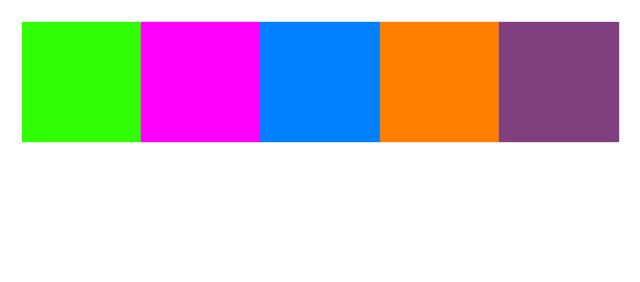

In [95]:
colors = distinctipy.get_colors(num_states)
cmap = gradient_cmap(colors)
distinctipy.color_swatch(colors,one_row=True)

Get names of observations for plotting purposes

In [96]:
obs_cols = []
for var in vars:
    obs_cols += [var+"{}".format(i) for i in range(-lag,0)] + [var+"+{}".format(i) for i in range(0,lag+1)]
obs_cols

['dist+0', 'atanh_cos_az+0', 'mouse_spd+0']

Selec trial and get data

In [97]:
trial_num = 211

# get trial obs
t_sel = (lag_df["trial_ID"]==trial_num)
t_obs = [np.vstack(lag_df[t_sel][var]) for var in vars]
t_obs = np.hstack(t_obs)
t_obs = stats.zscore(t_obs)

# get trial state seq
t_arhmm_z = lag_df[t_sel]["state"].to_numpy()

# print start/end frame
print("Trial ID: ",trial_num)
start = int(lag_df[t_sel]["frame"].min())
stop  = int(lag_df[t_sel]["frame"].max())

print("Start frame: ",start)
print("End frame: ",stop)

Trial ID:  211
Start frame:  1325
End frame:  10385


Plot segmented time series

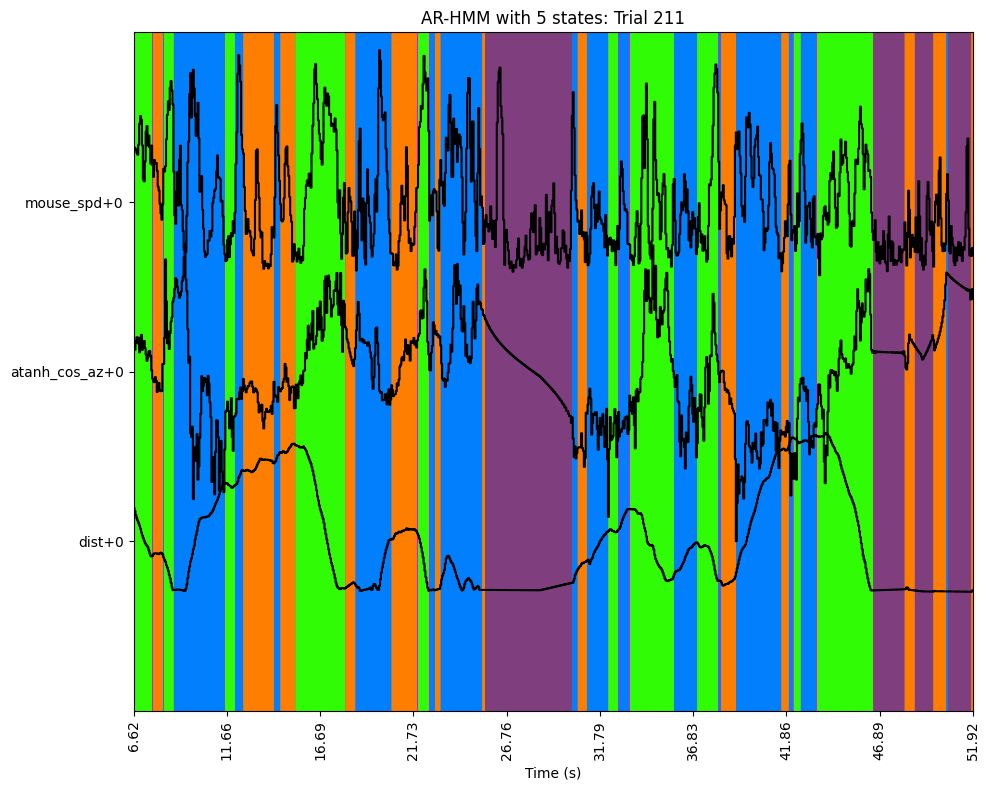

In [98]:
FPS = 200

# select range of frames to plot
start_frame, end_frame = start, stop
assert start_frame >= start
assert end_frame <= stop

# plot segmented time series
lim = 1.0 * abs(t_obs).max()
plt.figure(figsize=(10, 8))
plt.imshow(t_arhmm_z[None,0:end_frame-start_frame],aspect="auto",cmap=cmap, vmin=0,vmax=len(colors)-1,extent=(start_frame/FPS, end_frame/FPS, -lim, (obs_dim)*lim))
for d in range(obs_dim):
    ys = t_obs[0:end_frame-start_frame, d]
    xs = np.linspace(start_frame/FPS,end_frame/FPS,len(ys))
    plt.plot(xs,ys + lim*d, '-k', ds='steps-pre')
    #plt.xlim(start_frame,end_frame)
    plt.xlabel("Time (s)")
    plt.yticks(lim * np.arange(obs_dim),obs_cols)
    plt.title('AR-HMM with {} states: Trial {}'.format(num_states,trial_num))
    plt.xticks(np.linspace(start_frame/FPS,end_frame/FPS,10),rotation=90)
plt.tight_layout()

# Plot informative things
___

## Transition probability matrix

In [99]:
print("TPM:\n",np.matrix.round(arhmm.transitions.transition_matrix,3))

TPM:
 [[0.999 0.001 0.    0.    0.   ]
 [0.001 0.993 0.    0.003 0.003]
 [0.    0.001 0.997 0.001 0.001]
 [0.    0.003 0.001 0.993 0.002]
 [0.    0.003 0.001 0.003 0.994]]


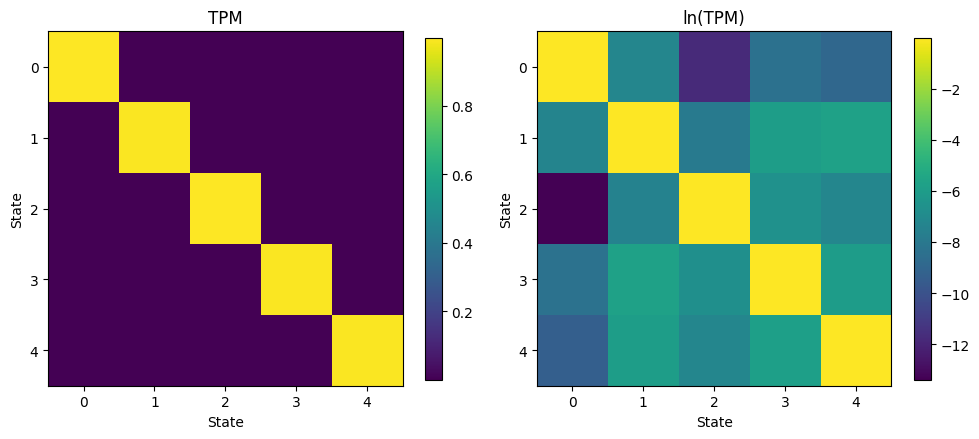

In [100]:
fig = plt.figure(figsize=(10,6))

# plot transition probability matrix (TPM)
fig.add_subplot(1,2,1)
plt.imshow(arhmm.transitions.transition_matrix)
plt.colorbar(shrink=0.6)
ticks = np.arange(0,num_states)
plt.xticks(ticks); plt.yticks(ticks)
plt.xlabel("State"); plt.ylabel("State")
plt.title("TPM")

# plot ln(TPM)
fig.add_subplot(1,2,2)
plt.imshow(np.log(arhmm.transitions.transition_matrix))
plt.colorbar(shrink=0.6)
plt.xticks(ticks); plt.yticks(ticks)
plt.xlabel("State"); plt.ylabel("State")
plt.title("ln(TPM)")
plt.tight_layout()

## Plot model parameters for each state

Autoregressive expected observations are:

$E[x_t | x_{t-1}, z_t=k, u_t] = \sum_{l=1}^{L} A_k^{(l)} x_{t-l} + b_k + V_k u_t$

where $L$ is the number of lags, $A_k$ & $b_k$ are the weights & biases for state $k$, $x_t$ are the observations, and $u_t$ are the inputs. 

For our model, we have no inputs ($u_t = 0$) and $L=1$:

$E[x_t | x_{t-1}, z_t=k] = A_k x_{t-1} + b_k$

Note that we can build in the desired number of lags by including them in our observations $x_t$.

Lets plot the weight matrices $A_k$, bias vectors $b_k$, and covariance

In [101]:
# get weights, biases, & covariance 
As = arhmm.observations.As # weights
bs = arhmm.observations.bs # biases
if obs_type=='diagonal_ar': covs = arhmm.observations.sigmasq
else: covs = arhmm.observations.Sigmas

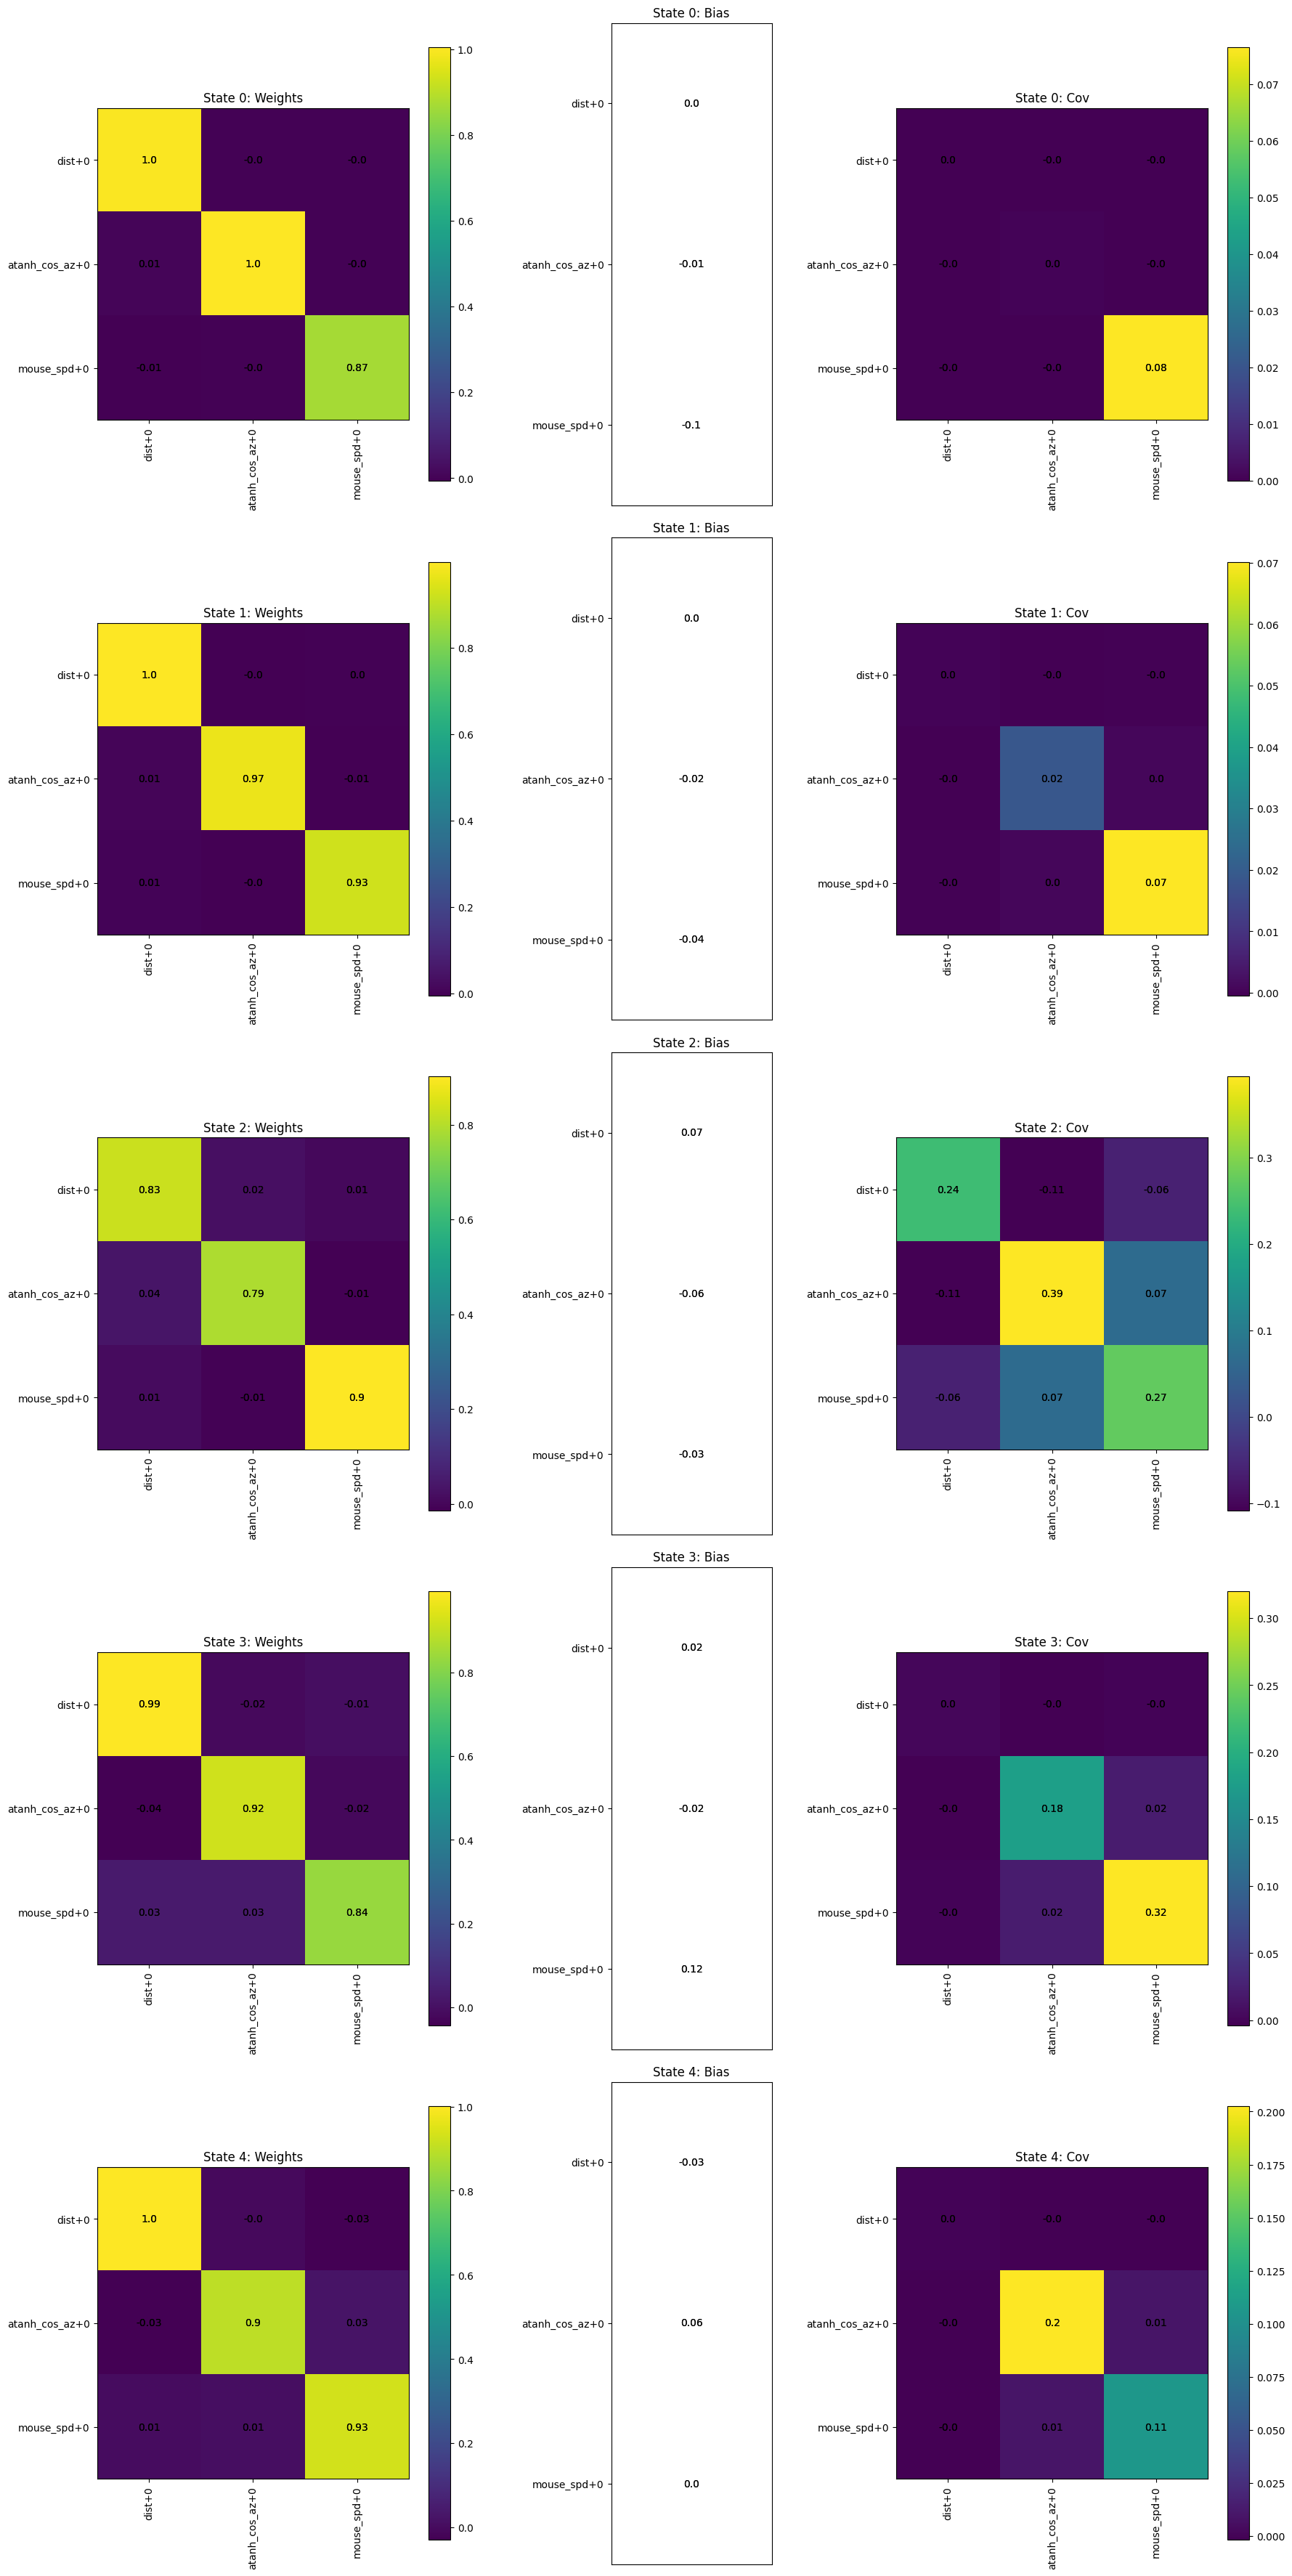

In [102]:
# points to round to
decimals = 2

# change figsize to me much larger if fitting many lags
figsize=(18,36)

# plot weights matrix, biases, diag cov
fig = plt.figure(figsize=figsize)
for s in range(num_states):
    
    # Weights
    ax = fig.add_subplot(num_states,3,3*s+1)
    plt.imshow(As[s])
    for (j,i),label in np.ndenumerate(As[s]):
        ax.text(i,j,round(label,decimals),ha="center",va="center")
        ax.text(i,j,round(label,decimals),ha="center",va="center")
    ticks = np.arange(len(obs_cols))
    ax.set_xticks(ticks); ax.set_xticklabels(obs_cols,rotation=90)
    ax.set_yticks(ticks); ax.set_yticklabels(obs_cols,rotation=0)
    plt.colorbar(shrink=0.9)
    ax.set_title("State {}: Weights".format(s))

    # Biases
    ax = fig.add_subplot(num_states,3,3*s+2)
    shaped_bs = np.reshape(bs[s],(-1,1))
    plt.imshow(0*shaped_bs,cmap='binary')
    for (j,i),label in np.ndenumerate(shaped_bs):
        ax.text(i,j,round(label,decimals),ha="center",va="center")
        ax.text(i,j,round(label,decimals),ha="center",va="center")
    ax.set_xticks([])
    ax.set_yticks(ticks); ax.set_yticklabels(obs_cols,rotation=0)
    #plt.colorbar()
    ax.set_title("State {}: Bias".format(s))

    # Covariance
    ax = fig.add_subplot(num_states,3,3*s+3)
    if obs_type=="ar":
        plt.imshow(covs[s])
        for (j,i),label in np.ndenumerate(covs[s]):
            ax.text(i,j,round(label,decimals),ha="center",va="center")
            ax.text(i,j,round(label,decimals),ha="center",va="center")    
        plt.colorbar(shrink=0.9)
        ax.set_title("State {}: Cov".format(s))
        ax.set_xticks(ticks); ax.set_xticklabels(obs_cols,rotation=90)
    else:
        shaped_covs = np.reshape(covs[s],(-1,1))
        plt.imshow(0*shaped_covs,cmap='binary')
        for (j,i),label in np.ndenumerate(shaped_covs):
            ax.text(i,j,round(np.sqrt(label),decimals),ha="center",va="center")
            ax.text(i,j,round(np.sqrt(label),decimals),ha="center",va="center")
        ax.set_title("State {}: Stdev".format(s))
        ax.set_xticks([])
    ax.set_yticks(ticks); ax.set_yticklabels(obs_cols,rotation=0)

plt.tight_layout()

## State durations

In [103]:
g_state_durr = [[] for _ in range(num_states)]
for g in lag_df['trial_ID'].unique():
    g_sel = (lag_df['trial_ID']==g)
    state_seq = lag_df[g_sel]['state'].to_numpy()
    state_trans = list(np.nonzero(state_seq[1:]-state_seq[:-1])[0] + 1)
    state_trans = [0] + state_trans
    n_frames = len(state_seq)
    if (n_frames) not in state_trans: state_trans += [n_frames]

    for i in range(len(state_trans)-1):
            seq = state_seq[state_trans[i]:state_trans[i+1]]
            state = np.unique(seq)
            assert len(state)==1
            g_state_durr[state[0]].append(len(seq))

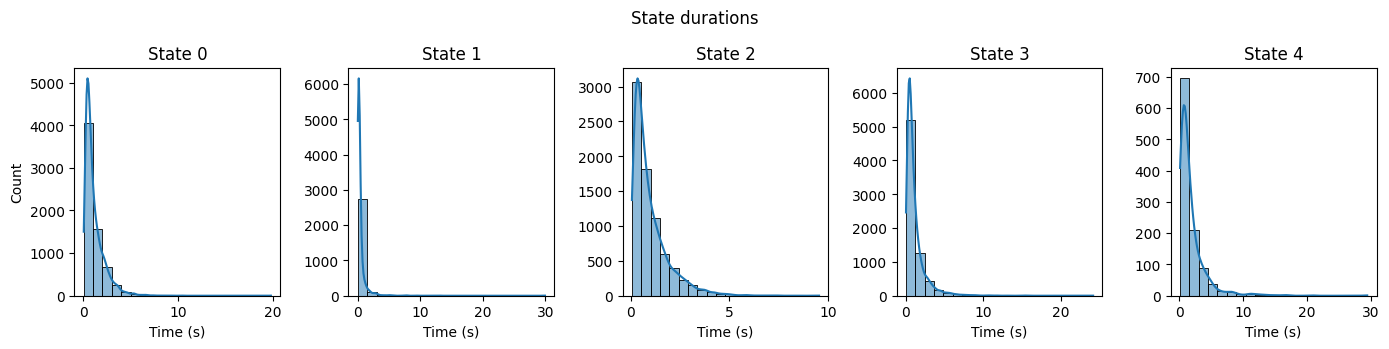

In [104]:
fig = plt.figure(figsize=(14,6))

for i in range(num_states):
    ax = fig.add_subplot(2, 5, i+1)
    # convert durations from frames to seconds
    state_dur_time = np.array(g_state_durr[i])*q/FPS
    sns.histplot(state_dur_time,bins=20,kde=True)
    ax.set_xlabel("Time (s)")
    plt.title("State {}".format(i))
    #ax.set_xlim(0,300)
    if i%5!=0: ax.set_ylabel("")
plt.suptitle("State durations")
plt.tight_layout()

# State contributions to LL
___

### Functions used to merge states, calculate likelihood drops, and plot results

In [ ]:
def merge_two_states(hmm, s1, s2, datas, inputs, observations, transitions):
    
    def collapse_and_sum_2d(arr, i, j, axis=0):
        assert axis <= 1
        out = arr.copy()
        if axis == 0:
            out[i,:] += out[j,:]
            return np.delete(out, j, axis=0)
        if axis == 1:
            out[:, i] += out[:, j]
            return np.delete(out, j, axis=1)
        
    K = hmm.K
    D = hmm.D
    assert K >= 2
    assert s1 < K
    assert s2 < K
    assert s1 != s2
    inputs = [np.ones((datas.shape[0],1))]
    datas = datas if isinstance(datas, list) else [datas]

    # if there are no inputs, we have to shape them into an array of 1s with shape (T,1)
    if inputs==None: inputs = [np.ones((datas[0].shape[0],1))]
    else: inputs = inputs if isinstance(inputs, list) else [inputs]
    # currently function does not support masks or tags
    masks, tags = [None], [None]
    expectations = [hmm.expected_states(data, input) for data, input in zip(datas, inputs)]
    
    # Merge expectations for 2 states
    expectations_new = []
    for (Ez, Ezz, py) in expectations:
        T_curr = Ez.shape[0]
        
        # Put merged expectations in first column
        Ez_new = collapse_and_sum_2d(Ez, s1, s2, axis=1)
        
        # Now merge Ezz
        # Ezz will have shape 1, K, K
        # so we get rid of the first dimension then add it back.
        Ezz_new = collapse_and_sum_2d(Ezz[0], s1, s2, axis=0)
        Ezz_new = collapse_and_sum_2d(Ezz_new, s1, s2, axis=1)
        Ezz_new = Ezz_new[None, :, :]
        expectations_new.append((Ez_new, Ezz_new, py))
    
    # Perform M-Step to get params for new hmm
    new_hmm = ssm.HMM(K-1, D, observations=observations, transitions=transitions)
    if transitions=="sticky": new_hmm.transitions.kappa = 1e6
    new_hmm.init_state_distn.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.transitions.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.observations.m_step(expectations_new, datas, inputs, masks, tags)
    
    # Evaluate log_likelihood
    expectations = [new_hmm.expected_states(data, input, mask, tag)
                    for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    new_ll = new_hmm.log_prior() + sum([ll for (_, _, ll) in expectations])
    return new_ll, new_hmm

In [ ]:
def make_similarity_matrix(hmm, data, input, observations, transitions):
    num_states = hmm.K
    init_ll = hmm.log_probability(data)
    similarity = np.nan * np.ones((num_states, num_states))
    merged_hmms = np.empty((num_states, num_states), dtype=object)
    for s1 in range(num_states-1):
        for s2 in range(s1+1, num_states):
            merged_ll, merged_hmm = merge_two_states(hmm, s1, s2, data, input, observations, transitions)
            similarity[s1, s2] = merged_ll - init_ll
            merged_hmms[s1, s2] = merged_hmm
            
    return similarity, merged_hmms

In [ ]:
color_names = ["s{}".format(i) for i in range(num_states)]

def hierarchical_cluster(hmm, data, input=None, observations="diagonal_ar", transitions="sticky", color_names=color_names):
    num_states = hmm.K
    linkage = [None]
    likelihood_drops = [0]
    hmms = [hmm]
    
    for i in range(num_states - 1):
        similarity, merged_hmms = make_similarity_matrix(hmms[-1], data, input, observations, transitions)
        
        # Find the most similar states
        s1, s2 = np.where(similarity == np.nanmax(similarity))
        s1, s2 = s1[0], s2[0]
        linkage.append((s1, s2))
        likelihood_drops.append(similarity[s1, s2])
        hmms.append(merged_hmms[s1, s2])
        print("merging ", color_names[s1], "and", color_names[s2])
    
    return linkage, likelihood_drops, hmms

In [ ]:
def dendrogram(num_states, linkage, likelihood_drops):
    fig = plt.figure()
    
    def _plot_level(s1, s2, likelihood_drop, xs, offset):
        new_offset = offset - likelihood_drop
        for x in xs:
            plt.plot([x, x], [offset, new_offset], '-k', lw=2)
        plt.plot([xs[s1], xs[s2]], [new_offset, new_offset], '-k', lw=2)

        new_xs = xs.copy()
        new_xs[s1] = xs[s1] + (xs[s2] - xs[s1]) * npr.rand()
        new_xs = np.concatenate([new_xs[:s2], new_xs[s2+1:]])
        return new_xs, new_offset
    
    xs = np.arange(num_states, dtype=float)
    offset = 0
    for (s1, s2), drop in zip(linkage[1:], likelihood_drops[1:]):
        xs, offset = _plot_level(s1, s2, drop, xs, offset)
    plt.xticks(np.arange(0,num_states))
        
    plt.xlabel("state")
    plt.ylabel("likelihood drop")

### See what states are most similar

WARNING: This takes a long time to run!!

In [132]:
linkage, likelihood_drops, hmms = hierarchical_cluster(arhmm, obs, observations="diagonal_ar", transitions="sticky", color_names=color_names)

KeyboardInterrupt: 

In [39]:
print("Order of merged states that result in least LL drops\n",linkage[1:])

Order of merged states that result in least LL drops
 [(8, 9), (5, 8), (0, 2), (2, 4), (1, 2), (0, 2), (0, 3), (0, 1), (0, 1)]


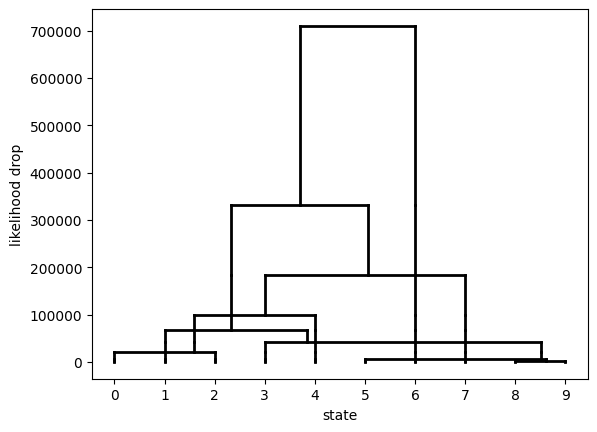

In [40]:
dendrogram(num_states, linkage, likelihood_drops)
#plt.ylim(0,10000)
plt.show()

# Cross validation
____

## Function for cross validation

In [456]:
def xval_func(data_in, num_states0, obs_type, trans_type, kappa=1e6):
    
    training_data  = data_in['training_data']
    test_data      = data_in['test_data']
    N_iters        = data_in['N_iters']
    TOL            = data_in['TOL']
    
    obs_dim   = len(training_data[0]) # number of observed dimensions: outcome
    nTrain    = len(training_data)
    nTest     = len(test_data)
    
    out = {}
    # Instantiate ARHMM & fit on training data
    mle_hmm = ssm.HMM(num_states0, obs_dim, observations=obs_type, transitions=trans_type)
    if trans_type=="sticky": 
        mle_hmm.transitions.kappa = kappa  #can tweak this sticky parameter
    hmm_lls = mle_hmm.fit(datas=training_data, N_iter=N_iters, tolerance=TOL)

    #Compute log-likelihood for each dataset
    out['ll_training'] = mle_hmm.log_likelihood(training_data)/nTrain
    out['ll_heldout']  = mle_hmm.log_likelihood(test_data)/nTest

    return out

## Cross validate with nKfold data split, nRunEM fits per state

In [460]:
#Create kfold cross-validation object which will split data for us
nKfold = 5
kf = KFold(n_splits=nKfold)

# define model types
trans_type = "sticky" # choose "stationary" or "sticky" transitions
obs_type   = "ar" # choose "ar" for full covariance, "diagonal_ar" for diag cov
kappa = 1e6 # sticky param

# define hyperparams
max_states = 10      # largest number of states allowed in the model selection
N_iters    = 200     # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance TOL
TOL        = 10e-6   # tolerance parameter (see N_iters)
nRunEM     = 3       # num. of times we run EM for each choice of number of states
NumThread = (multiprocessing.cpu_count()-5)*2 # CPUs to use

# initialized training and test loglik for model selection, and BIC
ll_training     = np.zeros((max_states,nKfold,nRunEM))
ll_heldout      = np.zeros((max_states,nKfold,nRunEM))

stN = np.flip(np.tile(np.arange(1,max_states+1),nRunEM))
RunN = np.repeat(np.arange(1,nRunEM+1),max_states,axis=0) 

print('Running parallel code with '+str(NumThread)+'workers')

# xval is over cv loops, states, and runs
for iK, (train_index, test_index) in enumerate(kf.split(obs)):
    nTrain = len(train_index)
    nTest  = len(test_index)
    # pack xval data into dict
    data_in = {'training_data':obs[train_index],'test_data':obs[test_index],'N_iters':N_iters,'TOL':TOL}
    results = Parallel(n_jobs=NumThread)(delayed(xval_func)(data_in, num_states0, 
                                                            obs_type, trans_type, kappa) for iRun,num_states0 in zip(RunN,stN))
    # unpack
    for i in range(max_states*nRunEM):
        ll_training[stN[i]-1,iK,RunN[i]-1] = results[i]['ll_training']
        ll_heldout[stN[i]-1,iK,RunN[i]-1]  = results[i]['ll_heldout']

Running parallel code with 182workers


LP: 859756.6: 100%|██████████| 100/100 [04:20<00:00,  2.61s/it]


In [461]:
np.save(path + 'prey_cap_ARHMM_ll_training.npy',ll_training)
np.save(path + 'prey_cap_ARHMM_ll_heldout.npy',ll_heldout)

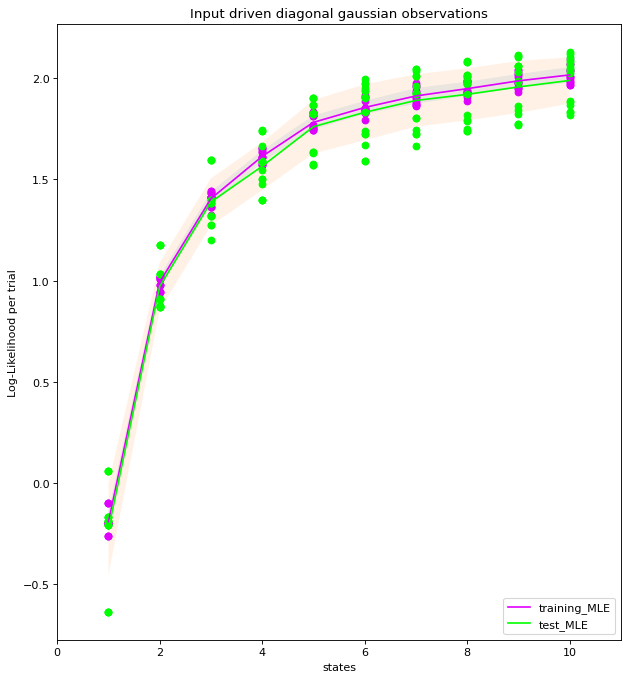

In [462]:
kindspline='quadratic'
# Plot the xval loglik 
fig = plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)

# reshape variables for plot
ll_training_plot = ll_training.reshape(max_states,nKfold*nRunEM)
ll_heldout_plot = ll_heldout.reshape(max_states,nKfold*nRunEM)

for iS, num_states in enumerate(range(1,max_states+1)):
    plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_training_plot[iS,:], color=colors[0], marker='o',lw=0)
    plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_heldout_plot[iS,:], color=colors[1], marker='o',lw=0)

x=range(1,max_states+1)
y=ll_training_plot.mean(axis=1); error=ll_training_plot.std(axis=1)
plt.plot(x,y, label="training_MLE", color=colors[0])
plt.fill_between(x,y-error, y+error,alpha=0.1)

y=ll_heldout_plot.mean(axis=1); error=ll_heldout_plot.std(axis=1)
plt.plot(x,y, label="test_MLE", color=colors[1])
plt.fill_between(x,y-error, y+error,alpha=0.1)

plt.legend(loc="lower right")
plt.xlabel("states")
plt.xlim(0, max_states+1)
plt.ylabel("Log-Likelihood per trial")
plt.title('Input driven diagonal gaussian observations')
plt.show()